# 1. Setup

## 1.1 Install Dependencies

In [1]:
import sys
print(sys.version) #tensorflow==2.4.1 tensorflow-gpu==2.4.1

3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]


In [4]:
!pip install "tensorflow>=2.16.1" opencv-python matplotlib 

  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached ml_dtypes-0.5.1-cp312-cp312-win_amd64.whl.metadata (22 kB)
Using cached ml_dtypes-0.5.1-cp312-cp312-win_amd64.whl (210 kB)
Using cached tensorboard-2.19.0-py3-none-any.whl (5.5 MB)
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.18.0 requires ml-dtypes<0.5.0,>=0.4.0, but you have ml-dtypes 0.5.1 which is incompatible.
tensorflow-intel 2.18.0 requires tensorboard<2.19,>=2.18, but you have tensorboard 2.19.0 which is incompatible.


In [5]:
!pip uninstall -y tensorflow-intel

Found existing installation: tensorflow_intel 2.18.0
Uninstalling tensorflow_intel-2.18.0:
  Successfully uninstalled tensorflow_intel-2.18.0


In [6]:
import tensorflow as tf
print(tf.__version__)

2.19.0


## 1.2 Import Dependencies

In [7]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [9]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Set GPU Growth

In [10]:
# Avoid OOM errors by setting GPU Memory Consumption Growth (ONLY DO THIS IF YOU HAVE GPU)
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [11]:
gpus

[]

## 1.4 Create Folder Structures

In [12]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [13]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [14]:
POS_PATH

'data\\positive'

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [15]:
# http://vis-www.cs.umass.edu/lfw/

In [17]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfwfunneled.tgz

In [22]:
# Move LFW Images to the following repository data/negative
LFW_PATH = "lfw_funneled"
NEG_PATH = "data/negative"  # make sure this exists

for item in os.listdir(LFW_PATH):
    item_path = os.path.join(LFW_PATH, item)
    if os.path.isdir(item_path):  # check if it's a directory
        for file in os.listdir(item_path):
            EX_PATH = os.path.join(item_path, file)
            NEW_PATH = os.path.join(NEG_PATH, file)
            os.replace(EX_PATH, NEW_PATH)

In [29]:
for directory in os.listdir(LFW_PATH): #THIS RETURNS NOTHING SEE THE WORKING VERSION FOR THE TUTORIAL IN THE DOCS
    dir_path = os.path.join(LFW_PATH, directory)
    if os.path.isdir(dir_path):  # Only process if it's a directory
        for file in os.listdir(dir_path):
            print(file)

## 2.2 Collect Positive and Anchor Classes

In [30]:
# Import uuid library to generate unique image names
import uuid

In [39]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))#each time we do this we are creating a unique identifier

'data\\anchor\\6e23c303-6779-11f0-a06b-88f4da30cb12.jpg'

In [40]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

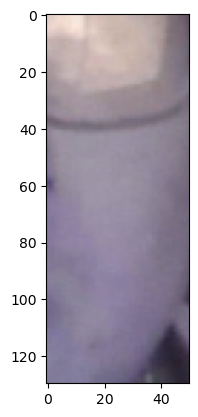

In [38]:
plt.imshow(frame[120:120+250,200:200+250, :])

# 2.x NEW - Data Augmentation

In [41]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [42]:
import os
import uuid

In [45]:
print(os.path.exists(img_path))        # Should be True
print(img_path)     
print(os.listdir(ANC_PATH))

False
data\anchor\924e839c-135f-11ec-b54e-a0cec8d2d278.jpg
['0f10c5b1-677a-11f0-b6de-88f4da30cb12.jpg', '0f5d0161-677a-11f0-84df-88f4da30cb12.jpg', '0f611a12-677a-11f0-bcf6-88f4da30cb12.jpg', '0f675277-677a-11f0-8500-88f4da30cb12.jpg', '0f6cc393-677a-11f0-bb5d-88f4da30cb12.jpg', '0f723335-677a-11f0-8e49-88f4da30cb12.jpg', '0f79c3f2-677a-11f0-8243-88f4da30cb12.jpg', '0f80b991-677a-11f0-8990-88f4da30cb12.jpg', '0f85b52c-677a-11f0-a4da-88f4da30cb12.jpg', '0f8a937a-677a-11f0-b9e5-88f4da30cb12.jpg', '0f9482ae-677a-11f0-ac56-88f4da30cb12.jpg', '0f99336f-677a-11f0-9f13-88f4da30cb12.jpg', '0fa5a0d0-677a-11f0-8612-88f4da30cb12.jpg', '0faa488f-677a-11f0-bced-88f4da30cb12.jpg', '0fb8f35b-677a-11f0-825c-88f4da30cb12.jpg', '0fbddc0e-677a-11f0-8006-88f4da30cb12.jpg', '0fd11fd2-677a-11f0-86e3-88f4da30cb12.jpg', '0fd5efe3-677a-11f0-b48c-88f4da30cb12.jpg', '0fe08590-677a-11f0-b2f8-88f4da30cb12.jpg', '0ffe250e-677a-11f0-bf49-88f4da30cb12.jpg', '100be1fc-677a-11f0-aeba-88f4da30cb12.jpg', '10119e96-677a-1

In [46]:
img_path = os.path.join(ANC_PATH, 'fe4a48b5-6779-11f0-b606-88f4da30cb12.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [47]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [52]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [57]:
dir_test = anchor.as_numpy_iterator()

In [58]:
print(dir_test.next())

b'data\\anchor\\1f6e8877-677a-11f0-b314-88f4da30cb12.jpg'


## 3.2 Preprocessing - Scale and Resize

In [59]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [60]:
img = preprocess('data\\anchor\\1f6e8877-677a-11f0-b314-88f4da30cb12.jpg')

In [61]:
img.numpy().max() #plt.imshow(img)

0.81397057

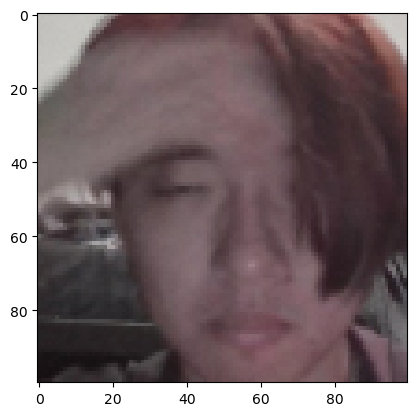

In [62]:
plt.imshow(img)

In [178]:
dataset.map(preprocess)

NameError: name 'dataset' is not defined

## 3.3 Create Labelled Dataset

In [63]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [64]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [65]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [66]:
samples = data.as_numpy_iterator()

In [67]:
exampple = samples.next()

In [68]:
exampple

(b'data\\anchor\\fce0a02a-6779-11f0-93b0-88f4da30cb12.jpg',
 b'data\\positive\\2f8af960-6836-11f0-9f83-88f4da30cb12.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [69]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [70]:
res = preprocess_twin(*exampple)

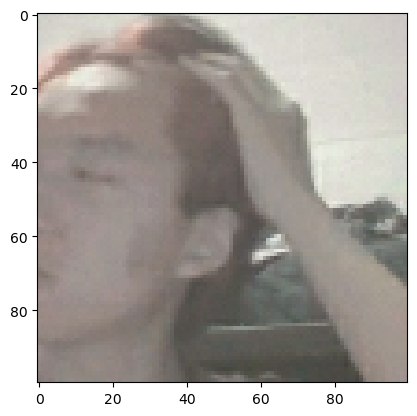

In [72]:
plt.imshow(res[1])

In [73]:
res[2]

1.0

In [74]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [80]:
samples = data.as_numpy_iterator()

In [92]:
samp = samples.next()

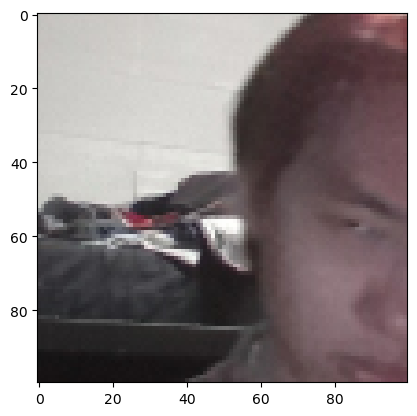

In [93]:
plt.imshow(samp[0])

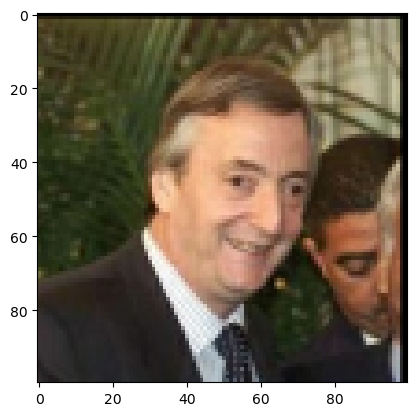

In [94]:
plt.imshow(samp[1])

In [95]:
samp[2]

0.0

In [97]:
round(len(data)*.7)

420

In [98]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [96]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [100]:
train_samples = train_data.as_numpy_iterator()

In [102]:
train_sample = train_samples.next()

In [103]:
len(train_sample[0])

16

In [106]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3)) #160
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [107]:
inp = Input(shape=(100,100,3), name='input_image')

In [108]:
inp

<KerasTensor shape=(None, 100, 100, 3), dtype=float32, sparse=False, ragged=False, name=input_image>

In [109]:
c1 = Conv2D(64, (10,10), activation='relu')(inp) #convolution has 64 filters 

In [110]:
c1

<KerasTensor shape=(None, 91, 91, 64), dtype=float32, sparse=False, ragged=False, name=keras_tensor>

In [111]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)#take max value out of 2 by 2 area to summarize

In [112]:
m1

<KerasTensor shape=(None, 46, 46, 64), dtype=float32, sparse=False, ragged=False, name=keras_tensor_1>

In [113]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [114]:
c2

<KerasTensor shape=(None, 40, 40, 128), dtype=float32, sparse=False, ragged=False, name=keras_tensor_2>

In [115]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [116]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1) #final layer

In [117]:
c3

<KerasTensor shape=(None, 17, 17, 128), dtype=float32, sparse=False, ragged=False, name=keras_tensor_4>

In [118]:
c4

<KerasTensor shape=(None, 6, 6, 256), dtype=float32, sparse=False, ragged=False, name=keras_tensor_6>

In [120]:
f1 #9216 6*6*256

<KerasTensor shape=(None, 9216), dtype=float32, sparse=False, ragged=False, name=keras_tensor_7>

In [121]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [122]:
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                     ┃ Output Shape            ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)         │ (None, 100, 100, 3)     │             0 │
├──────────────────────────────────┼─────────────────────────┼───────────────┤
│ conv2d (Conv2D)                  │ (None, 91, 91, 64)      │        19,264 │
├──────────────────────────────────┼─────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)     │ (None, 46, 46, 64)      │             0 │
├──────────────────────────────────┼─────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)                │ (None, 40, 40, 128)     │       401,536 │
├──────────────────────────────────┼─────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)   │ (None, 20, 20, 128)     │             0 │
├──────────────────────────────────┼─────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)                │ (None, 17, 17, 128)     │       262,272 │
├──────────────────────────────────┼─────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)   │ (None, 9, 9, 128)       │             0 │
├──────────────────────────────────┼─────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)                │ (None, 6, 6, 256)       │       524,544 │
├──────────────────────────────────┼─────────────────────────┼───────────────┤
│ flatten (Flatten)                │ (None, 9216)            │             0 │
├──────────────────────────────────┼─────────────────────────┼───────────────┤
│ dense (Dense)                    │ (None, 4096)            │    37,752,832 │
└──────────────────────────────────┴─────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [123]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [124]:
embedding = make_embedding()

In [125]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                     ┃ Output Shape            ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)         │ (None, 100, 100, 3)     │             0 │
├──────────────────────────────────┼─────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)                │ (None, 91, 91, 64)      │        19,264 │
├──────────────────────────────────┼─────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)   │ (None, 46, 46, 64)      │             0 │
├──────────────────────────────────┼─────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)                │ (None, 40, 40, 128)     │       401,536 │
├──────────────────────────────────┼─────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)   │ (None, 20, 20, 128)     │             0 │
├──────────────────────────────────┼─────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)                │ (None, 17, 17, 128)     │       262,272 │
├──────────────────────────────────┼─────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)   │ (None, 9, 9, 128)       │             0 │
├──────────────────────────────────┼─────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)                │ (None, 6, 6, 256)       │       524,544 │
├──────────────────────────────────┼─────────────────────────┼───────────────┤
│ flatten_1 (Flatten)              │ (None, 9216)            │             0 │
├──────────────────────────────────┼─────────────────────────┼───────────────┤
│ dense_1 (Dense)                  │ (None, 4096)            │    37,752,832 │
└──────────────────────────────────┴─────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

## 4.2 Build Distance Layer

In [126]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [127]:
l1 = L1Dist()

In [129]:
l1

<L1Dist name=l1_dist, built=False>

In [128]:
l1(anchor_embedding, validation_embedding)

NameError: name 'anchor_embedding' is not defined

## 4.3 Make Siamese Model

In [143]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [144]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [145]:
inp_embedding

[<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, ragged=False, name=keras_tensor_21>]

In [146]:
siamese_layer = L1Dist()

In [148]:
print(type(inp_embedding), type(val_embedding))
print(inp_embedding)

<class 'list'> <class 'list'>
[<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, ragged=False, name=keras_tensor_21>]


In [149]:
distances = siamese_layer(inp_embedding[0], val_embedding[0])

In [150]:
classifier = Dense(1, activation='sigmoid')(distances)

In [151]:
classifier

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_24>

In [152]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [153]:
siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)         ┃ Output Shape      ┃    Param # ┃ Connected to       ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ input_img            │ (None, 100, 100,  │          0 │ -                  │
│ (InputLayer)         │ 3)                │            │                    │
├──────────────────────┼───────────────────┼────────────┼────────────────────┤
│ validation_img       │ (None, 100, 100,  │          0 │ -                  │
│ (InputLayer)         │ 3)                │            │                    │
├──────────────────────┼───────────────────┼────────────┼────────────────────┤
│ embedding            │ (None, 4096)      │ 38,960,448 │ input_img[0][0],   │
│ (Functional)         │                   │            │ validation_img[0]… │
├──────────────────────┼───────────────────┼────────────┼────────────────────┤
│ l1_dist_4 (L1Dist)   │ (None, 4096)      │          0 │ embedding[3][0],   │
│                      │                   │            │ embedding[4][0]    │
├──────────────────────┼───────────────────┼────────────┼────────────────────┤
│ dense_3 (Dense)      │ (None, 1)         │      4,097 │ l1_dist_4[0][0]    │
└──────────────────────┴───────────────────┴────────────┴────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [156]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image)[0], embedding(validation_image)[0])
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [157]:
siamese_model = make_siamese_model()

In [158]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)         ┃ Output Shape      ┃    Param # ┃ Connected to       ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ input_img            │ (None, 100, 100,  │          0 │ -                  │
│ (InputLayer)         │ 3)                │            │                    │
├──────────────────────┼───────────────────┼────────────┼────────────────────┤
│ validation_img       │ (None, 100, 100,  │          0 │ -                  │
│ (InputLayer)         │ 3)                │            │                    │
├──────────────────────┼───────────────────┼────────────┼────────────────────┤
│ embedding            │ (None, 4096)      │ 38,960,448 │ input_img[0][0],   │
│ (Functional)         │                   │            │ validation_img[0]… │
├──────────────────────┼───────────────────┼────────────┼────────────────────┤
│ l1_dist_6 (L1Dist)   │ (None, 4096)      │          0 │ embedding[7][0],   │
│                      │                   │            │ embedding[8][0]    │
├──────────────────────┼───────────────────┼────────────┼────────────────────┤
│ dense_4 (Dense)      │ (None, 1)         │      4,097 │ l1_dist_6[0][0]    │
└──────────────────────┴───────────────────┴────────────┴────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# 5. Training

## 5.1 Setup Loss and Optimizer

In [159]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [160]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [222]:
import shutil
checkpoint_dir = r"C:\Users\mdngu\OneDrive\Máy tính\Face Recognition\FaceRecognition\training_checkpoints"
# If it's a file, remove it
if os.path.exists(checkpoint_dir) and not os.path.isdir(checkpoint_dir):
    os.remove(checkpoint_dir)
# If it's somehow a broken directory or you want to fully reset it:
elif os.path.isdir(checkpoint_dir):
    shutil.rmtree(checkpoint_dir)
    
os.makedirs(checkpoint_dir, exist_ok=True)  # Creates folder if it doesn't exist

checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [223]:
print("Current working directory:", os.getcwd())
print("Checkpoint will be saved to:", checkpoint_prefix)
print(f"Exists: {os.path.exists(checkpoint_dir)}")
print(f"Is dir: {os.path.isdir(checkpoint_dir)}")
print(f"Is file: {os.path.isfile(checkpoint_dir)}")
parent_dir = os.path.dirname(checkpoint_dir)
print("Contents of parent directory:", os.listdir(parent_dir))
print("Listing contents:", os.listdir(checkpoint_dir) if os.path.isdir(checkpoint_dir) else "Not a directory")
#checkpoint.save(file_prefix=checkpoint_prefix)

Current working directory: C:\Users\mdngu\OneDrive\Máy tính\Face Recognition\FaceRecognition
Checkpoint will be saved to: C:\Users\mdngu\OneDrive\Máy tính\Face Recognition\FaceRecognition\training_checkpoints\ckpt
Exists: True
Is dir: True
Is file: False
Contents of parent directory: ['.git', '.ipynb_checkpoints', 'data', 'Facial Verification with a Siamese Network - Final.ipynb', 'Facial Verification with a Siamese Network - Part 1.ipynb', 'Facial Verification with a Siamese Network - Part 2.ipynb', 'Facial Verification with a Siamese Network - Part 4.ipynb', 'Facial Verification with a Siamese Network - Part 5.ipynb', 'Facial Verification with a Siamese Network - Part 7.ipynb', 'lfwfunneled.tgz', 'lfw_funneled', 'training_checkpoints']
Listing contents: []


## 5.3 Build Train Step Function

In [224]:
test_batch = train_data.as_numpy_iterator()

In [225]:
batch_1 = test_batch.next()

In [226]:
len(batch_1) 

3

In [227]:
X = batch_1[:2]

In [228]:
np.array(X).shape

(2, 16, 100, 100, 3)

In [229]:
y = batch_1[2]

In [230]:
y

array([1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1.],
      dtype=float32)

In [231]:
tf.losses.BinaryCrossentropy??

Init signature:
tf.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='sum_over_batch_size',
    name='binary_crossentropy',
    dtype=None,
)
Source:        
@keras_export("keras.losses.BinaryCrossentropy")
class BinaryCrossentropy(LossFunctionWrapper):
    """Computes the cross-entropy loss between true labels and predicted labels.

    Use this cross-entropy loss for binary (0 or 1) classification applications.
    The loss function requires the following inputs:

    - `y_true` (true label): This is either 0 or 1.
    - `y_pred` (predicted value): This is the model's prediction, i.e, a single
        floating-point value which either represents a
        [logit](https://en.wikipedia.org/wiki/Logit), (i.e, value in [-inf, inf]
        when `from_logits=True`) or a probability (i.e, value in [0., 1.] when
        `from_logits=False`).

    Args:
        from_logits: Whether to interpret `y_pred` as a tensor of
            [logit](htt

In [232]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

## 5.4 Build Training Loop

In [233]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [234]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        #if epoch % 10 == 0: 
        #    checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [235]:
EPOCHS = 50

In [236]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━

# 6. Evaluate Model

## 6.1 Import Metrics

In [237]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [238]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [239]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[2.3019193e-09],
       [1.0112012e-07],
       [1.0000000e+00],
       [9.9999964e-01],
       [1.0000000e+00],
       [9.9245567e-10],
       [1.0000000e+00],
       [1.4037212e-07],
       [1.7625074e-09],
       [8.5944613e-10],
       [1.0000000e+00],
       [4.9004806e-10],
       [1.6043957e-07],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.7118301e-08]], dtype=float32)

In [252]:
# Post processing the results 
[1 if prediction < 0.5 else 0 for prediction in y_hat ]

[1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1]

In [251]:
y_true

array([1., 1., 0., 0.], dtype=float32)

## 6.3 Calculate Metrics

In [242]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [243]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [244]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1.0 1.0


## 6.4 Viz Results

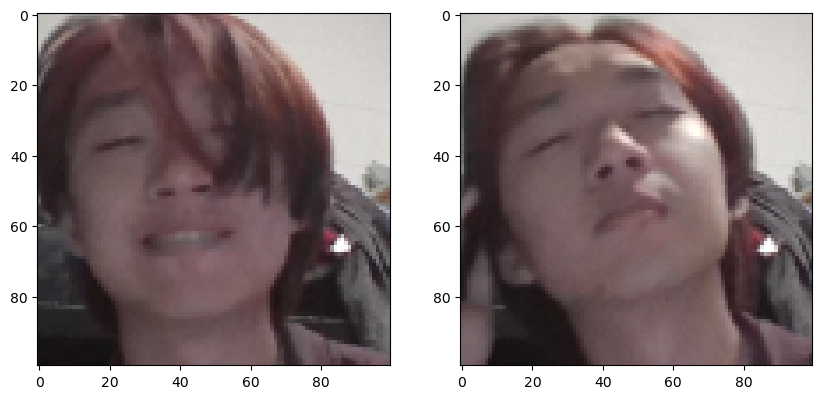

In [259]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[1])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[1])

# Renders cleanly
plt.show()
#To see a different batch and find out where you can get the next batch

# 7. Save Model

In [260]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [261]:
L1Dist

__main__.L1Dist

In [262]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [263]:
tf.keras.models.load_model??

Signature:
tf.keras.models.load_model(
    filepath,
    custom_objects=None,
    compile=True,
    safe_mode=True,
)
Source:   
@keras_export(["keras.saving.load_model", "keras.models.load_model"])
def load_model(filepath, custom_objects=None, compile=True, safe_mode=True):
    """Loads a model saved via `model.save()`.

    Args:
        filepath: `str` or `pathlib.Path` object, path to the saved model file.
        custom_objects: Optional dictionary mapping names
            (strings) to custom classes or functions to be
            considered during deserialization.
        compile: Boolean, whether to compile the model after loading.
        safe_mode: Boolean, whether to disallow unsafe `lambda` deserialization.
            When `safe_mode=False`, loading an object has the potential to
            trigger arbitrary code execution. This argument is only
            applicable to the Keras v3 model format. Defaults to `True`.

    Returns:
        A Keras model instance. If the or

In [264]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


array([[1.0000000e+00],
       [9.9999285e-01],
       [1.4007276e-05],
       [4.9805340e-08]], dtype=float32)

In [265]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)         ┃ Output Shape      ┃    Param # ┃ Connected to       ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ input_img            │ (None, 100, 100,  │          0 │ -                  │
│ (InputLayer)         │ 3)                │            │                    │
├──────────────────────┼───────────────────┼────────────┼────────────────────┤
│ validation_img       │ (None, 100, 100,  │          0 │ -                  │
│ (InputLayer)         │ 3)                │            │                    │
├──────────────────────┼───────────────────┼────────────┼────────────────────┤
│ embedding            │ (None, 4096)      │ 38,960,448 │ input_img[0][0],   │
│ (Functional)         │                   │            │ validation_img[0]… │
├──────────────────────┼───────────────────┼────────────┼────────────────────┤
│ l1_dist_7 (L1Dist)   │ (None, 4096)      │          0 │ embedding[0][0],   │
│                      │                   │            │ embedding[1][0]    │
├──────────────────────┼───────────────────┼────────────┼────────────────────┤
│ dense_4 (Dense)      │ (None, 1)         │      4,097 │ l1_dist_7[0][0]    │
└──────────────────────┴───────────────────┴────────────┴────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# 8. Real Time Test

## 8.1 Verification Function

In [268]:
application_data\verification_images

SyntaxError: unexpected character after line continuation character (2818603333.py, line 1)

In [269]:
os.listdir(os.path.join('application_data', 'verification_images'))

['28895670-6836-11f0-85bf-88f4da30cb12.jpg',
 '29063836-6836-11f0-9ec4-88f4da30cb12.jpg',
 '29677796-6836-11f0-9b71-88f4da30cb12.jpg',
 '2a1a82fa-6836-11f0-b98c-88f4da30cb12.jpg',
 '2ab19027-6836-11f0-af71-88f4da30cb12.jpg',
 '2ac47097-6836-11f0-a261-88f4da30cb12.jpg',
 '2aca6459-6836-11f0-8f3a-88f4da30cb12.jpg',
 '2acfd72b-6836-11f0-ba4e-88f4da30cb12.jpg',
 '2acffe86-6836-11f0-bd65-88f4da30cb12.jpg',
 '2ad02590-6836-11f0-8952-88f4da30cb12.jpg',
 '2ad02591-6836-11f0-8ab9-88f4da30cb12.jpg',
 '2ad04c9d-6836-11f0-bc55-88f4da30cb12.jpg',
 '2ad04c9e-6836-11f0-81fd-88f4da30cb12.jpg',
 '2ad073ad-6836-11f0-9e41-88f4da30cb12.jpg',
 '2ad073ae-6836-11f0-b3b0-88f4da30cb12.jpg',
 '2ad09a71-6836-11f0-a85c-88f4da30cb12.jpg',
 '2ad61903-6836-11f0-914e-88f4da30cb12.jpg',
 '2ad64013-6836-11f0-ba1e-88f4da30cb12.jpg',
 '2ad666d0-6836-11f0-b467-88f4da30cb12.jpg',
 '2ad666d1-6836-11f0-8f9f-88f4da30cb12.jpg',
 '2ad68e69-6836-11f0-a758-88f4da30cb12.jpg',
 '2ad68e6a-6836-11f0-a08f-88f4da30cb12.jpg',
 '2ad6b541

In [270]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [271]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\28895670-6836-11f0-85bf-88f4da30cb12.jpg
application_data\verification_images\29063836-6836-11f0-9ec4-88f4da30cb12.jpg
application_data\verification_images\29677796-6836-11f0-9b71-88f4da30cb12.jpg
application_data\verification_images\2a1a82fa-6836-11f0-b98c-88f4da30cb12.jpg
application_data\verification_images\2ab19027-6836-11f0-af71-88f4da30cb12.jpg
application_data\verification_images\2ac47097-6836-11f0-a261-88f4da30cb12.jpg
application_data\verification_images\2aca6459-6836-11f0-8f3a-88f4da30cb12.jpg
application_data\verification_images\2acfd72b-6836-11f0-ba4e-88f4da30cb12.jpg
application_data\verification_images\2acffe86-6836-11f0-bd65-88f4da30cb12.jpg
application_data\verification_images\2ad02590-6836-11f0-8952-88f4da30cb12.jpg
application_data\verification_images\2ad02591-6836-11f0-8ab9-88f4da30cb12.jpg
application_data\verification_images\2ad04c9d-6836-11f0-bc55-88f4da30cb12.jpg
application_data\verification_images\2ad04c9e-6836-11f0-81fd-88f

In [272]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verification

In [280]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━

In [276]:
np.sum(np.squeeze(results) > 0.9)

45

In [278]:
45/50

0.9

In [277]:
results

[array([[0.9999358]], dtype=float32),
 array([[0.99985707]], dtype=float32),
 array([[0.99998426]], dtype=float32),
 array([[0.99996495]], dtype=float32),
 array([[0.94631815]], dtype=float32),
 array([[0.99993044]], dtype=float32),
 array([[0.99994653]], dtype=float32),
 array([[0.907051]], dtype=float32),
 array([[0.98663896]], dtype=float32),
 array([[0.99812764]], dtype=float32),
 array([[0.999418]], dtype=float32),
 array([[0.9997863]], dtype=float32),
 array([[0.99990106]], dtype=float32),
 array([[0.9999557]], dtype=float32),
 array([[0.9999687]], dtype=float32),
 array([[0.9999792]], dtype=float32),
 array([[0.46968502]], dtype=float32),
 array([[0.9920773]], dtype=float32),
 array([[0.99843687]], dtype=float32),
 array([[0.9979265]], dtype=float32),
 array([[0.999268]], dtype=float32),
 array([[0.9999204]], dtype=float32),
 array([[0.99995303]], dtype=float32),
 array([[0.99993396]], dtype=float32),
 array([[0.9999609]], dtype=float32),
 array([[0.09897403]], dtype=float32),
 